# CNN - CIFAR10 - Data Augmentation

In [ ]:
# First, import TF and get its version.
import tensorflow as tf
tf_version = tf.__version__

# Check if version >=2.0.0 is used
if not tf_version.startswith('2.'):
    print('\033[91m' + 'WARNING: TensorFlow >= 2.0.0 will be used in this course.\nYour version is {}'.format(tf_version) + '.\033[0m')
else:
    print('\033[92m' + 'OK: TensorFlow >= 2.0.0' + '.\033[0m')

OK: TensorFlow >= 2.0.0.


## Loading the packages

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import utils
from sklearn.metrics import confusion_matrix

%matplotlib inline

Define a function to plot some images from CIFAR and load the dataset.

170500096/170498071 [==============================] - 4s 0us/step


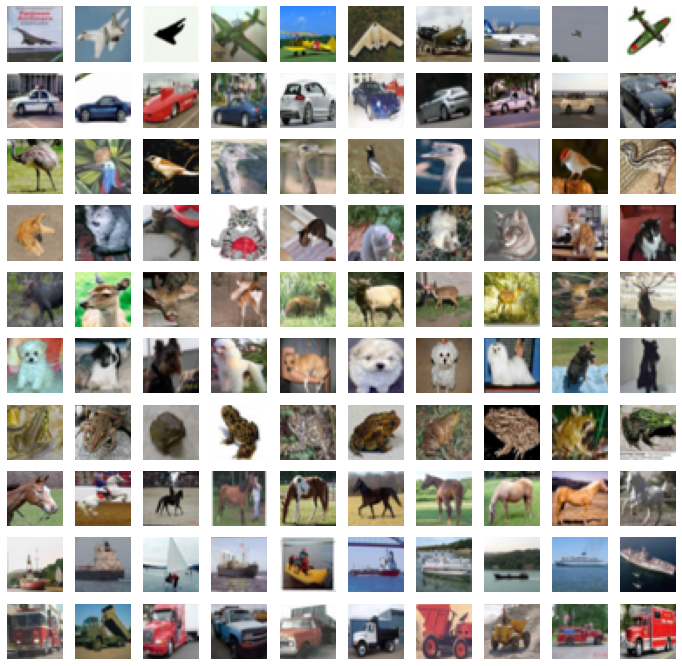

training input shape :  (50000, 32, 32, 3)
training output shape:  (50000, 1)
testing input shape  :  (10000, 32, 32, 3)
testing output shape :  (10000, 1)


In [ ]:
def show_imgs(X,y):
    plt.figure(1, figsize=(12,12))
    k = 0
    for i in range(0,10):
        for j in range(0,10):
            while y[k] != i: k += 1
            plt.subplot2grid((10,10),(i,j))
            plt.imshow(X[k])
            plt.axis('off')
            k += 1
    plt.show()

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
show_imgs(X_test, y_test)
print('training input shape : ', X_train.shape)
print('training output shape: ', y_train.shape)
print('testing input shape  : ', X_test.shape)
print('testing output shape : ', y_test.shape)

### Preprocessing data
After loading and splitting the data, we need to preprocess them by reshaping them into the shape the network expects and scaling them so that all values are in the \[0, 1\] interval.

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

50000 train samples
10000 test samples


The target values of the network are supposed to be 1-hot targets. Now the `y_train` is an array with scalar values as in `[5 0 4 1 ...]` and it should be a 1-hot array `Y_train` as in : 

`[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]...]`
 
Note the change of capital letter in the `Y_train` to denote, per convention, an array with multiple dimensions.

In [13]:
n_classes = 10
Y_train = utils.to_categorical(y_train, n_classes)
Y_test = utils.to_categorical(y_test, n_classes)
print(Y_test[:10])

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Define the network
The neural network will be a CNN. Follow the structure given in the exercise 1.

In [16]:
cnn = Sequential()
cnn.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', input_shape=(32, 32, 3)))
cnn.add(Activation('relu'))
cnn.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(n_classes, activation='softmax'))


cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_3 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_4 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
activation_5 (Activation)    (None, 16, 16, 32)       

## Compile and train the network

When compiling the model, we need to specify the loss function, the optimizer and the metrics we want to track during the training. In Keras, we need to call the methods `compile()` and `fit()`. We will train through E epochs, using batches of size B, as specified in the exercise 1.

- The `categorical_crossentropy` loss is relevant for multiclass, single-label classification problem. Categorical is used because there are 10 classes to predict from. If there were 2 classes, we would have used `binary_crossentropy`.
- The `adam` optimizer is an improvement over SGD(Stochastic Gradient Descent). The optimizer is defining the update rule for the weights of the neurons during backpropagation gradients.

In [15]:
print('training input shape : ', X_train.shape)
print('training output shape: ', Y_train.shape)
print('testing input shape  : ', X_test.shape)
print('testing output shape : ', Y_test.shape)

training input shape :  (50000, 32, 32, 3)
training output shape:  (50000, 10)
testing input shape  :  (10000, 32, 32, 3)
testing output shape :  (10000, 10)


In [41]:
cnn.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
log1 = cnn.fit(X_train, Y_train, batch_size=128, epochs=10,
                    verbose=1, validation_data=(X_test, Y_test))

Epoch 1/10
391/391 [==============================] - 135s 343ms/step - loss: 0.4862 - accuracy: 0.8324 - val_loss: 0.6580 - val_accuracy: 0.7862
Epoch 2/10
391/391 [==============================] - 133s 341ms/step - loss: 0.4322 - accuracy: 0.8489 - val_loss: 0.6840 - val_accuracy: 0.7790
Epoch 3/10
391/391 [==============================] - 133s 340ms/step - loss: 0.4130 - accuracy: 0.8548 - val_loss: 0.6814 - val_accuracy: 0.7799
Epoch 4/10
391/391 [==============================] - 132s 339ms/step - loss: 0.3939 - accuracy: 0.8640 - val_loss: 0.7024 - val_accuracy: 0.7814
Epoch 5/10
391/391 [==============================] - 132s 339ms/step - loss: 0.3764 - accuracy: 0.8709 - val_loss: 0.7298 - val_accuracy: 0.7736
Epoch 6/10
391/391 [==============================] - 132s 338ms/step - loss: 0.3607 - accuracy: 0.8753 - val_loss: 0.7127 - val_accuracy: 0.7813
Epoch 7/10
391/391 [==============================] - 132s 338ms/step - loss: 0.3452 - accuracy: 0.8801 - val_loss: 0.7486 -

In [42]:
np.average(log1.history['accuracy']) #Average Train Accuracy

0.8652319967746734

## Evaluate the network

We can do this at three levels: (1) plot of the loss during the training phase, (2) overall accuracy evaluation on test set and (3) per class evaluation with confusion matrix on test set.

### Loss and accuracy evolution during training
This can be done first looking at the history of the training (output of the `fit()` function).

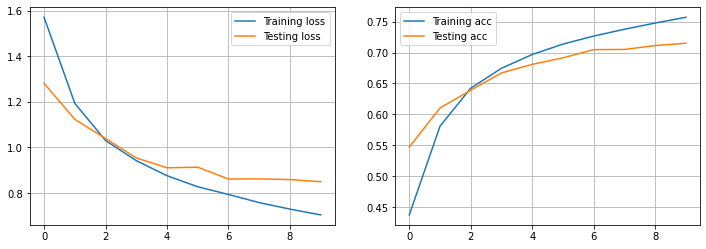

In [18]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

### Model evaluation
We can compute the overall performance on test set calling the `evaluate()` function on the model. The function returns the loss and the metrics used to compile the models.

In [19]:
loss_test, metric_test = cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

Test loss: 0.8499515652656555
Test accuracy: 0.7150999903678894


### Confusion matrix
We can call the `predict_classes()` function to get the predicted classes. The output of this function is an array with the predicted class labels as in `[5 0 4 1 ...]`. The output array of ground truth `y_test` and the predicted classes can then be fed to the `confusion_matrix()` function of [sklearn metrics package](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix).

In [20]:
pred = cnn.predict_classes(X_test, verbose=0)
confusion_matrix(y_test, pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[812,  26,  19,  20,  10,  15,   6,  17,  50,  25],
       [ 37, 844,   4,   7,   4,   5,   3,   6,  19,  71],
       [105,  11, 476,  54, 137, 107,  42,  42,  14,  12],
       [ 29,  16,  43, 516,  67, 232,  33,  35,  15,  14],
       [ 34,   4,  42,  59, 707,  43,  15,  84,  11,   1],
       [ 17,   3,  24, 136,  44, 709,   8,  45,   7,   7],
       [  9,  12,  39,  79,  75,  55, 714,   8,   6,   3],
       [ 22,   3,  19,  30,  57,  80,   1, 779,   2,   7],
       [ 75,  49,  12,  11,   4,   8,   2,   4, 814,  21],
       [ 34,  94,   6,  18,   7,   7,   2,  23,  29, 780]])

## Data Augmentation

Overfitting can be caused by having networks with too many parameters that are trained on too few samples. Through training, the model learns *by hart* and generalizes poorly.

**Data augmentation** takes the approach of generating artificially more training data from existing training samples. For images, data augmentation is performed via a number of random transformations that yield believable-looking images. The goal is that at training time, the model will not see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the ```ImageDataGenerator``` instance.

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X_train, Y_train, batch_size=128)
val_batches = gen.flow(X_test, Y_test, batch_size=128)

Don't forget to reset your network (by defining it again). You need then to compile the network and train it. The call to the `fit()` function has to be replaced by a call to `fit_generator()` and using the data flow defined above. 

In [23]:
cnn.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

log = cnn.fit_generator(batches, steps_per_epoch=50000//128, epochs=50,
                    validation_data=val_batches, validation_steps=10000//128)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
390/390 [==============================] - 162s 415ms/step - loss: 0.8969 - accuracy: 0.6877 - val_loss: 0.9369 - val_accuracy: 0.6794
Epoch 2/50
390/390 [==============================] - 161s 412ms/step - loss: 0.8513 - accuracy: 0.7027 - val_loss: 0.8907 - val_accuracy: 0.6961
Epoch 3/50
390/390 [==============================] - 160s 411ms/step - loss: 0.8298 - accuracy: 0.7150 - val_loss: 0.8963 - val_accuracy: 0.6947
Epoch 4/50
390/390 [==============================] - 161s 413ms/step - loss: 0.8170 - accuracy: 0.7152 - val_loss: 0.8627 - val_accuracy: 0.7049
Epoch 5/50
390/390 [==============================] - 161s 413ms/step - loss: 0.8063 - accuracy: 0.7194 - val_loss: 0.8562 - val_accuracy: 0.7052
Epoch 6/50
390/390 [==============================] - 161s 413ms/step - loss: 0.7899 - accuracy: 0.7265 - val_loss: 0.8757 - val_accuracy: 0.6959
Epoch 7/50
390/390 [==============================] - 161s 413ms/step - loss: 0.7772 - accuracy: 0.7312 - val_loss: 0.8774 -

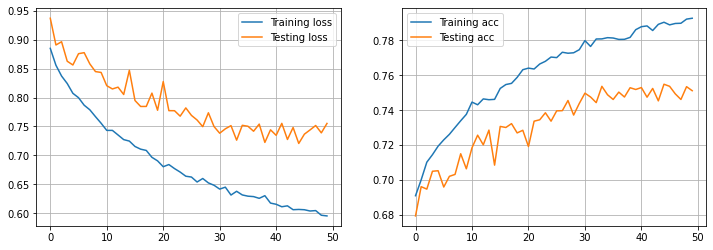

In [24]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [25]:
loss_test, metric_test = cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

Test loss: 0.7979460954666138
Test accuracy: 0.7476999759674072


In [26]:
np.average(log.history['accuracy']) #Average Train Accuracy

0.7617741429805756

In [ ]:
gen2 = ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2, height_shift_range=0.2,
        rescale=1./255, shear_range=0.2,
        zoom_range=0.2, horizontal_flip=True,
        fill_mode='nearest'))
batches2 = gen2.flow(X_train, Y_train, batch_size=128)
val_batches2 = gen2.flow(X_test, Y_test, batch_size=128)

In [ ]:
log = cnn.fit_generator(batches2, steps_per_epoch=50000//128, epochs=50,
                    validation_data=val_batches2, validation_steps=10000//128, use_multiprocessing=True))

### Table of results

Describe your data augmentation strategies here.

| CNN | Architecture description | Acc. train | Acc. test |
|-----|--------------------------|------------|-----------|
|  No DA | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.86523  | 0.71509 |
|  With DA v1 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.761774  | 0.74769 |
|  With DA v2 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | ...  | ... |


## Exercise 2 Visualisation of Activations



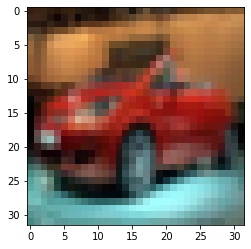

In [33]:
test_im1 = X_train[45] #car
plt.imshow(test_im1)
plt.show()

test_im1 = test_im1.reshape(1,32,32,3)

In [34]:
def plot_activations(activations, n_fig_x, n_fig_y): #n_fig_x * n_fig_y < 32
    plt.figure(1, figsize=(15,15))
    k = 0
    for i in range(0, n_fig_x):
        for j in range(0, n_fig_y):
            plt.subplot2grid((n_fig_x, n_fig_y), (i, j))
            plt.axis('off')
            plt.matshow(activations[0, :, :, k], fignum=False, cmap='Greys')
            k = k+1
    plt.show()


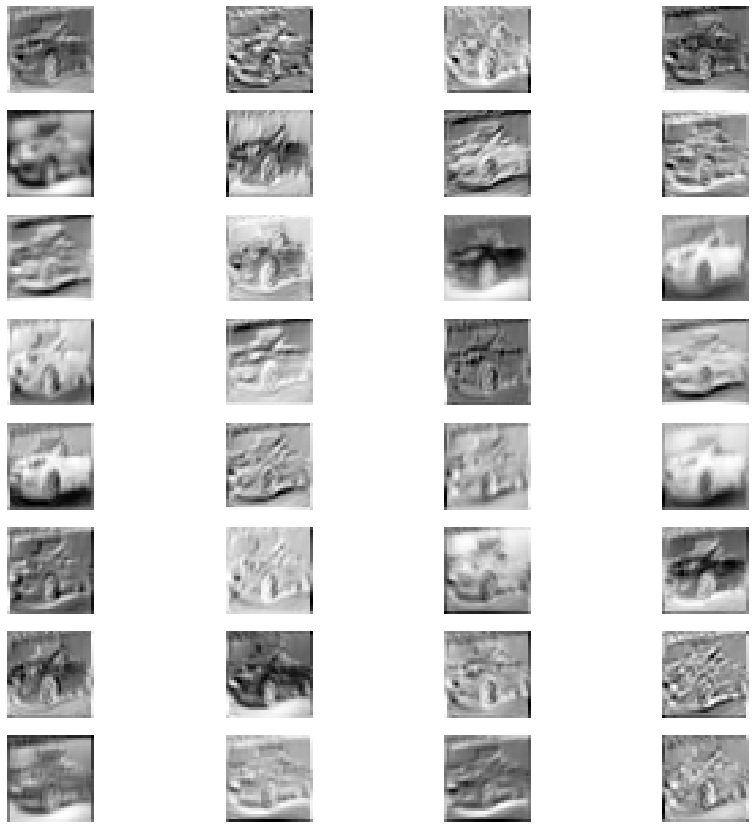

In [35]:
from tensorflow.keras import models

layer_1st_conv = cnn.layers[0].output
activation_model = models.Model(inputs=cnn.input, outputs=layer_1st_conv)
first_layer_activation = activation_model.predict(test_im1)
plot_activations(first_layer_activation, 8, 4)

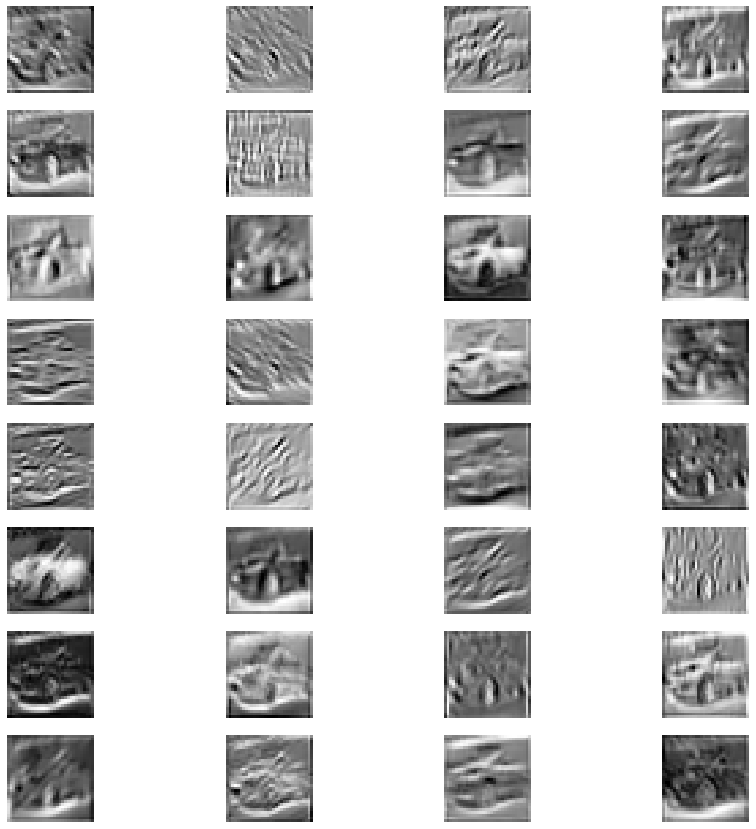

In [36]:
from tensorflow.keras import models

layer_2nd_conv = cnn.layers[2].output
activation_model2 = models.Model(inputs=cnn.input, outputs=layer_2nd_conv)
second_layer_activation = activation_model2.predict(test_im1)
plot_activations(second_layer_activation, 8, 4)

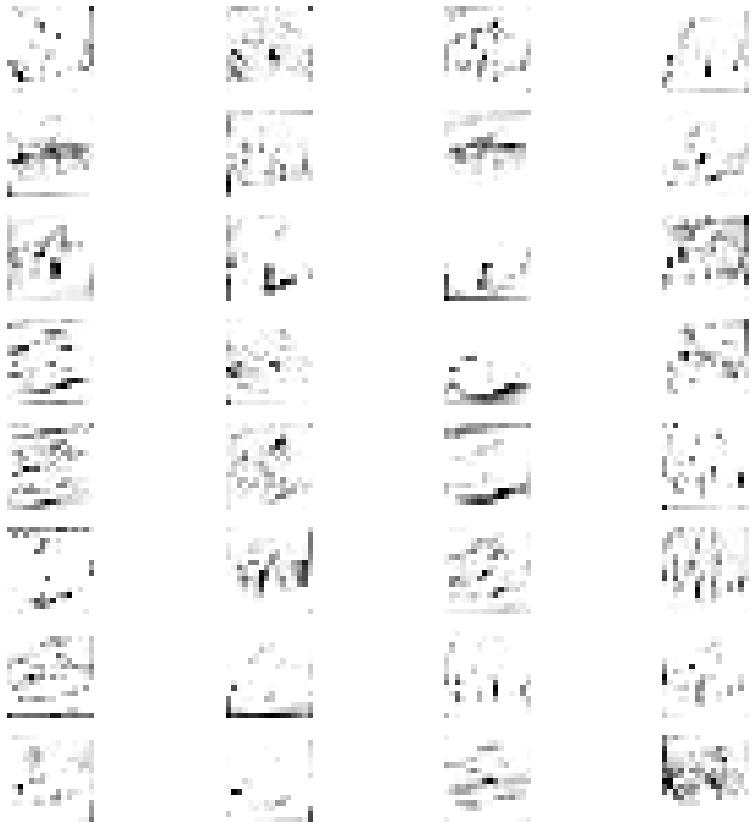

In [37]:
from tensorflow.keras import models

layer_pool = cnn.layers[4].output
activation_model3 = models.Model(inputs=cnn.input, outputs=layer_pool)
pool_activation = activation_model3.predict(test_im1)
plot_activations(pool_activation, 8, 4)

##Exercise 3 Optional : Deeper Models

In [38]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

#VG- GNet : [[Conv2D → relu → BN]*3 → MaxPool2D → Dropout]*4 → Flatten → Dense → Dropout → Out.

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (32,32,3)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(10, activation = "softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)       

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3, 
                         height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X_train, Y_train, batch_size=256)
val_batches = gen.flow(X_test, Y_test, batch_size=256)

In [40]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

log = model.fit_generator(batches, steps_per_epoch=50000//256, epochs=75, validation_data=val_batches, 
                          validation_steps=10000//256, use_multiprocessing=True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/75
  4/195 [..............................] - ETA: 6:07 - loss: 3.1516 - accuracy: 0.1002

Process Keras_worker_ForkPoolWorker-1:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [ ]:
loss_test, metric_test = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

##Exercise 5 Optional : Review Questions
**a) Explain the notion of hierarchical features with CNNs.** <br>

**b) Explain 2 strategies to visualise the modelling taking place in CNNs.**<br>
The first strategy is visualing the activation maps.<br>
The second strategy is finding input images that maximising the activation of a given neuron by applying update rule which uses backprob. of the gradient of the activation function a_i,j(x) until it convergence.
<br>
![](https://i.imgur.com/JcuHJ4M.png)

**c) What do we try to fight when using data augmentation ?**<br>
When lack the quantity and diversity of data, it helps us to increase the size of the dataset and introduce variability in the dataset, without actually collecting new data.
Moreover, it reduces over fitting.<br>
**d) What are the implementation strategies for data augmentation ?**<br>Offline Data Augmentation is when you increase the size of your data by performing the transformations before it the data is feed into the model. <br>
Online Data Augmentation is when you perform the transformation on the mini-batches used to feed the model. This is preferred in larger datasets as it not possible to deal with a huge increase in size of the data.<br>

**e) Explain the main differences for the deep architectures seen in class : AlexNet, VGGNet, GoogLeNet(Inception), ResNet. What were their intuitions when putting together such architectures ?**<br>
In the table below these four CNNs are sorted w.r.t their accuracy on the Imagenet dataset. <br>
The number of trainable parameters and the Floating Point Operations (FLOP) required for a forward pass can also be seen.
![](https://miro.medium.com/max/700/1*p-2QjvJ4nDCfn3F5oIxvYA.png)
AlexNet and ResNet-152, both have about 60M parameters but there is about a 10% difference in accuracy where training a ResNet-152 requires almost 10 times more computation than that of AlexNet, which means more training time and energy required.
<br>
VGGNet not only has a higher number of parameters and FLOP as compared to ResNet-152 but also has a decreased accuracy. It takes more time to train a VGGNet with reduced accuracy.
<br>
Training an AlexNet takes almost the same time as training Inception where Inception's memory requirements(number of parameters) are 10 times less with improved accuracy.

